# Using Python Hamiltonian Monte Carlo for Analysis in the Flash Method
File: pyhmc_flash_1DHL.pynb

Jozef Gembarovic 2/24/2016

### One Dimensional Flash Model with heat losses
Analytical formula for temperature response at the rear face of the sample ($x=L$, $t>0$) is
$$ T(t, a, B_1, B_2) = \sum_{i=0}^\infty \frac{ 2\gamma_i^2(\gamma_i^2+B_2^2)\big(\cos{\gamma_i}+\frac{B_1}{\gamma_i}\sin{\gamma_i}\big)}{(\gamma_i^2+B_1^2)(\gamma_i^2+B_2^2)+(B_1+B_2)(\gamma_i^2+B_1B_2)}\exp{\big[-\gamma_i^2\frac{at}{L^2}\big]}, $$
where $\gamma_i$, $i=1,2,3,\dots$, are positive roots of 
$$ (\gamma^2-B_1B_2)\sin{\gamma} - (B_1+B_2)\cos{\gamma}=0.$$

$B_1$ and $B_2$ are Biot numbers for the front and rear side of the sample, resp. 

In [82]:
import scipy.special as scs # for Bessel functions (special functions in the Scientific Python package)
from scipy.optimize import brenth # for finding zero of a function
#  conda install -c https://conda.anaconda.org/omnia pyhmc
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
np.random.seed(1234)
import pymc
#  the sampler
from pyhmc import hmc

# transcendental functions for eigenvalues calculations
def funA(x,bio): 
    return (x*x - bio**2)*np.sin(x) - (2*bio)*x*np.cos(x)
    

# define Biot numbers for front, rear, radial of a cylindrical shape sample
L = 1
#R = 5
#Biot_theor = 0.1
#Bio = Biot_theor

def rootsearch(f,a1,b1,Bio,dx):
    x1 = a1; f1 = f(a1, Bio)
    x2 = a1 + dx; f2 = f(x2, Bio)
    while f1*f2 > 0.0:
        if x1 >= b1:
            return None,None
        x1 = x2; f1 = f2
        x2 = x1 + dx; f2 = f(x2, Bio)
    return x1,x2


def mroots(f, Bio, a1, b1, eps=1e-2):
    #print ('The roots on the interval [%f, %f] are:' % (a,b))
    i=0
    myroots=[]
    while 1:
        x1,x2 = rootsearch(f,a1,b1,Bio,eps)
        if x1 != None:
            a1 = x2
            #root = bisect(f,x1,x2,1)
            root = brenth(f,x1,x2, Bio, xtol=1e-16)
            if root != None:
                pass
       #     print ('root',i, root, f(root, Bio))
            myroots.append(root)
            i = i+1
        else:
            #print ('\nDone')
            return myroots
            
            break


In [83]:
def flash1DHL( a, b, c, t): # One dimensional model with heat losses
    
    # calculate eigenvalues - root of the transcendental functions
    gamas = mroots(funA, b, 0.0001, 200)
    
    Bi1=b
    Bi2=b

    g2 = list(np.array(gamas)**2)
    suma=0.0
    for i in range(0, len(gamas)):
       suma = suma + 2*g2[i]*(g2[i]+Bi2**2)/((g2[i]+Bi1**2)*(g2[i]+Bi2**2)
       +(Bi1+Bi2)*(g2[i]+Bi1*Bi2))*(np.cos(gamas[i])+Bi1/gamas[i]
       *np.sin(gamas[i]))*np.exp(-g2[i]*a*t/L**2)  
    
    return c*suma

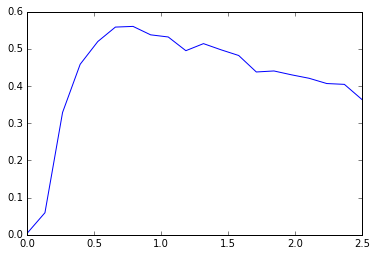

In [84]:

# define your probability distribution

def logprob(x, t, y, sigma, N ):
#    logp = -0.5 * np.sum(ivar * x**2)
#    grad = -ivar * x
    # ivar = [Tmax, alpha]
    yey = np.zeros(N)
    ey = np.zeros(N)
    ey0 = np.zeros(N)
    ey1 = np.zeros(N)
    ey2 = np.zeros(N)
    grad = np.zeros(2)
    for i in range(0, 9):
        ey[i] = flash1DHL(x[1], x[2], x[0], t[i])
        ey0[i] = ey[i]*1.005 # tmax
        ey1[i] = flash1DHL(x[1]*1.005, x[2], x[0], t[i]) # alpha
        ey2[i] = flash1DHL(x[1], x[2]*1.005, x[0], t[i]) # Biot
    
    yey = np.matrix(y - ey)
    
    yey0 = np.matrix(y - ey0)
    yey1 = np.matrix(y - ey1)
    yey2 = np.matrix(y - ey2)
    
    logp = -(yey * (np.transpose(yey)))/(2*sigma**2)
    
    logpx0 = -(yey0 * (np.transpose(yey0)))/(2*sigma**2)
    logpx1 = -(yey1 * (np.transpose(yey1)))/(2*sigma**2)
    logpx2 = -(yey2 * (np.transpose(yey2)))/(2*sigma**2)
    
    grad = np.array([(logp - logpx0)/x[0],(logp - logpx1)/x[1],(logp - logpx2)/x[2] ])
    grad = np.array([grad.item(0), grad.item(1), grad.item(2)])
    return logp.item(0), -grad

N=20 # why it is not working properly for N > 30 ???
t = np.linspace(0.001,2.5,N)
sigma = 0.01
a_theor = 0.5 # alpha
b_theor = 0.25 # Biot number
c_theor = 0.75 # tmax
y = np.asarray(flash1DHL(a_theor, b_theor, c_theor, t)) + np.random.normal(0,sigma,N)
#logprob([3.0,0.5,0.5],t,y,sigma, N)
plt.plot(t,y) ;                       
#y*np.transpose(y)

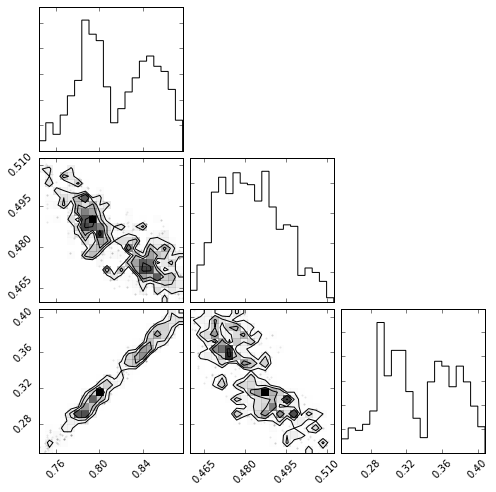

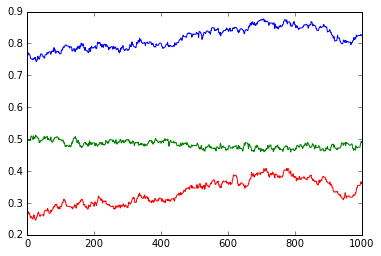

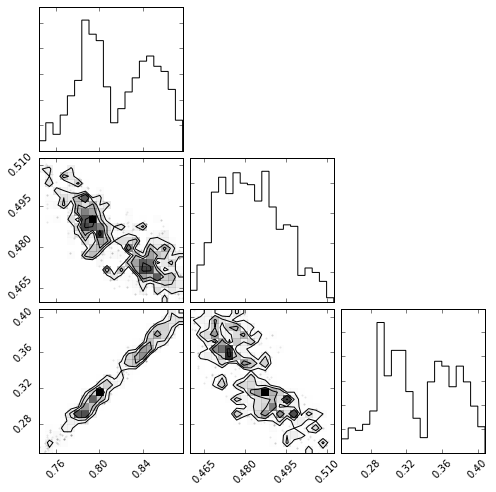

In [85]:
x00 = np.asarray([0.8, 0.4, 0.2])
samples = hmc(logprob, x0=x00, args=(t,y,sigma,N,), epsilon=0.005, n_samples=1e3, display=0, n_burn=100)
# Optionally, plot the results (requires an external package)
import triangle  # pip install triangle_plot
plt.plot(samples)
triangle.corner(samples)
#figure = triangle.corner(samples)
#figure.savefig('triangle.png')

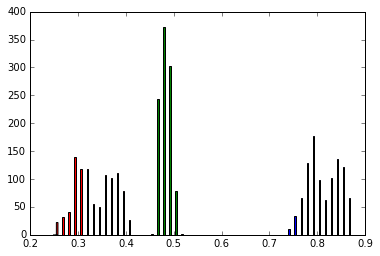

In [86]:
plt.hist(samples,50);

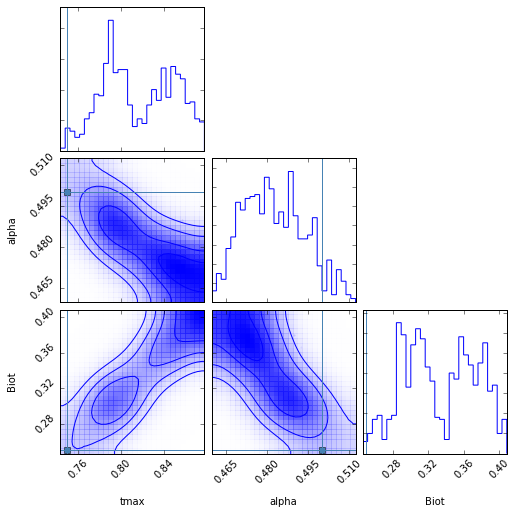

In [87]:
import corner
figure = corner.corner(samples, color="b", bins=30, filled= False, smooth=(5),fill_contours=False,
                       labels=['tmax','alpha', 'Biot'], 
                truths=[0.75, 0.5,0.25])
figure.savefig('pyhmc_flash_1DHL_triangle.png')

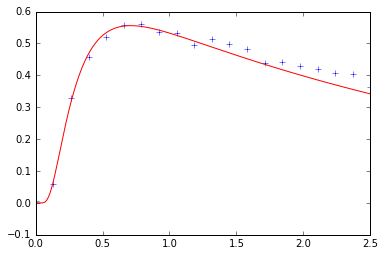

In [88]:
# reconstruct the temperature rise
# calculate average values of tmax and alpha
m = np.mean(samples, axis=0)
std = np.std(samples, axis=0)
ttheor = np.linspace(0.001,2.5,500)
ytheor = flash1DHL(m[1], m[2], m[0], ttheor)
figure = plt.plot(t,y,"+", ttheor,ytheor,"red") 

fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
ax.plot(t,y,"+", ttheor,ytheor,"red")
fig.savefig('pyhmc_flash_1DHL_rise_2.png')   # save the figure to file
plt.close(fig)    # close the figure

In [89]:
m, std

(array([ 0.81609449,  0.48264025,  0.3327182 ]),
 array([ 0.03299784,  0.01119895,  0.04012489]))